# 4. Non symmetric qubits: expected value of n vs purity

This notebook corresponds to the MSPRT applyied for three partially symmetric qubits. It considers two different measurements and compute the expected value of n vs purity for both of them.

Cells 1-3 define the needed parameters and functions.

Cell 4 computes a loop of sequential tests with fixed error and plots the average n vs purity for both measurements.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Rotacio(omega,vector):
    a = np.cos(omega)*vector[0]-np.sin(omega)*vector[1] 
    b = np.sin(omega)*vector[0]+np.cos(omega)*vector[1]
    return np.array((a,b))

def probabilitats(rho,pi,i):
    A = np.zeros(len(pi))
    for k in range(len(pi)):
        A[k] = np.trace(np.dot(pi[k],rho[i]))
    return abs(A)
         
def likelihood_ratio(tirs,prob_matrix, priors):
    a,b,c = priors[0],priors[1],priors[2]
    # prob_matrix[0].shape[1] és el nombre de outputs
    for k in range(prob_matrix[0].shape[1]):
        a *=  prob_matrix[0,k]**tirs[k]
        b *=  prob_matrix[1,k]**tirs[k]
        c *=  prob_matrix[2,k]**tirs[k]
    return np.array((a/(a+b+c),b/(a+b+c), c/(a+b+c)))

In [3]:
prior0= 1/3
prior1 = 1/3
prior2 = 1/3
priors = [prior0,prior1,prior2]
theta = np.pi
omega = np.pi/2
#
psitheta0 = np.array((np.cos(theta/2), np.sin(theta/2)))
psitheta1 = Rotacio(np.pi/3,psitheta0)
psitheta2 = Rotacio(2*np.pi/3,psitheta0)
pi0 = (2/3)*np.tensordot(psitheta0,psitheta0,axes=0)
pi1 = (2/3)*np.tensordot(psitheta1,psitheta1,axes=0)
pi2 = (2/3)*np.tensordot(psitheta2,psitheta2,axes=0)
pis = [pi0,pi1,pi2]
#
ephi0 = np.array((0,1)) 
ephi1 = Rotacio(omega/2,ephi0)
ephi2 = Rotacio(-omega/2,ephi0)
epi0 = np.tensordot(ephi0,ephi0, axes = 0)
epi1 = np.tensordot(ephi1,ephi1, axes = 0)
epi2 = np.tensordot(ephi2,ephi2, axes = 0)
esumpi = epi0+epi1+epi2
w,v = np.linalg.eig(esumpi)
mu = np.amax(w)

E0 = (1/mu)*epi0
E1 = (1/mu)*epi1
E2 = (1/mu)*epi2
Ed = np.identity(len(ephi0))-(1/mu)*esumpi
Es = [E0,E1,E2,Ed]

POVM = [pis,Es]

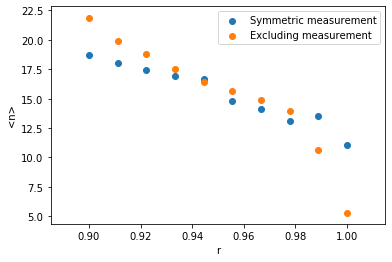

In [4]:
particions = 10
loops = 100
alpha = 0.00001
vsoroll = np.linspace(0.9,1,particions)
    
n_promig0 = np.zeros(particions)
n_promig1 = np.zeros(particions)

txt0 = np.zeros((particions,2))
txt1 = np.zeros((particions,2))

for k in range(particions): 
    r = np.repeat(vsoroll[k],3)
    omega = 2*np.pi/4

    psi0 = np.array((1,0))
    psi1 = Rotacio(omega/2,psi0)
    psi2 = Rotacio(-omega/2,psi0)
    rho0 = r[0]*np.tensordot(psi0,psi0,axes = 0)+(1-r[0])*np.identity(2)/2
    rho1 = r[1]*np.tensordot(psi1,psi1,axes = 0)+(1-r[1])*np.identity(2)/2
    rho2 = r[2]*np.tensordot(psi2,psi2,axes = 0)+(1-r[2])*np.identity(2)/2
    rho = [rho0,rho1,rho2]
    for o in range(2):
        pi = POVM[o]
        prob_matrix = np.matrix([probabilitats(rho,pi,0),probabilitats(rho,pi,1),probabilitats(rho,pi,2)])
        errors = 0
        n_tirades = []
        n_tirades0 = []
        n_tirades1 = []
        for i in range (loops):
            estat = np.random.choice(3, p = priors)
            m = 1
            output = 0
            tirs = np.zeros(len(pi))

            tirades=[0]
            while m >= 0:
                output = np.random.choice(len(pi),p = probabilitats(rho,pi,estat))
                tirades.append(output)
                tirs[output] += 1

                n = m

                for i in range(3):
                    if likelihood_ratio(tirs,prob_matrix,priors)[i]>=1-alpha:
                        m = -10
                        if i != estat:
                            errors += 1
                m+=1
            n_tirades.append(n)
        if o == 0:
            n_promig0[k] = np.sum(n_tirades) /loops
        elif o == 1:
            n_promig1[k] = np.sum(n_tirades) /loops   
        
    txt0[k,0] = vsoroll[k]
    txt0[k,1] = n_promig0[k]
    txt1[k,0] = vsoroll[k]
    txt1[k,1] = n_promig1[k]

#np.savetxt("nvsnoise0.txt",txt0)
#np.savetxt("nvsnoise1.txt",txt1)
fig, ax = plt.subplots()
ax.scatter(vsoroll,n_promig0, label= "Symmetric measurement")
ax.scatter(vsoroll,n_promig1, label= "Excluding measurement")
ax.set_xlabel("r")
ax.set_ylabel("<n>")
ax.legend()
plt.show()